In [1]:
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import os
import glob
from obspy import read, Stream
from obspy.core.util import AttribDict
import numpy as np
import pandas as pd
from phasepickers.parker_cfs import src_rec_dist
from datetime import datetime as datetime
from scipy.spatial.distance import cdist
import pickle

In [2]:

geomcols=np.arange(8)
wellcols=np.arange(12)
CASSMGeom=pd.read_excel('/home/spri902/Collab_metadata/SigmaV_Channel_Monitoring_Rev_1.0_PetrovMod.xlsx',\
                        sheet_name='Geode',header=0,usecols=geomcols)
CASSMMeq = CASSMGeom.drop(index=[23,27,28,29,36,37,38,45,46,47,54,55,56,63,64,65,72,73,74,\
    78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95])
CASSMsrc=pd.read_excel('/home/spri902/Collab_metadata/SigmaV_Channel_Monitoring_Rev_1.0_PetrovMod.xlsx',\
                        sheet_name='CASSM_Channels',header=0,usecols=geomcols)
CASSMsrc.columns = [c.replace(' ','_') for c in CASSMsrc.columns]
WellGeom=pd.read_excel('/home/spri902/Collab_metadata/Well_Points.xlsx',header=0,usecols=wellcols)
# Bring in MEQ catalog
meq = pd.read_csv('/home/spri902/EGS_Collab/4850/MEQ/catalog_manual_all_v190312.csv')
dates = mdates.date2num(meq['date'])
meq['datenums'] = dates
meq = meq[(meq['date'] > '2018-05-22T00') & (meq['date'] < '2018-05-25T24')]


/home/spri902/anaconda3/envs/obspy/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/spri902/anaconda3/envs/obspy/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
path = '/data1/parker/EGS_MEQ/eventfiles_raw/'
fileList = sorted(os.listdir('/data1/parker/EGS_MEQ/eventfiles_raw'))
eventid = 548
st = Stream()
dat = read(os.path.join(path,fileList[eventid]))
dat = dat[:60]
dat.pop(23)

SV.OT12..XN1 | 2018-05-25T15:24:37.943969Z - 2018-05-25T15:24:37.973969Z | 100000.0 Hz, 3001 samples

In [4]:
i=0
for trdat in dat:
    trdat.detrend("spline",order=3,dspline=50)
    trdat.filter("bandpass",freqmin=5000,freqmax=20000,corners=4,zerophase=True)
    srcloc = meq.loc[eventid,'x':'z'].values
    srcloc = srcloc.reshape(-1,3).astype(float)    
    recloc = CASSMMeq.iloc[i,5:].values
    recloc = recloc.reshape(-1,3).astype(float)
    dist = np.round(src_rec_dist(srcloc,recloc),2)
    trdat.stats['distance'] = dist
    trdat.stats['coordinates'] = AttribDict({
        'x':recloc[0,0],
        'elevation': recloc[0,2],
        'y': recloc[0,1]
    })
    st += trdat
    i+=1


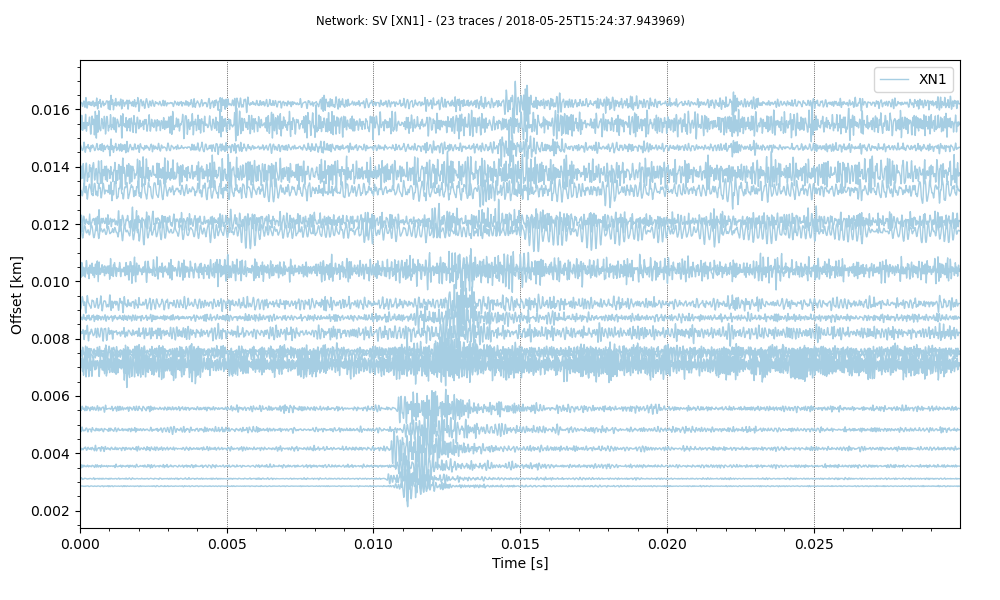

In [5]:
hydros =st[:23].plot(type='section',scale=2,orientation='horizontal',color='channel',handle=True,alpha=1.0)

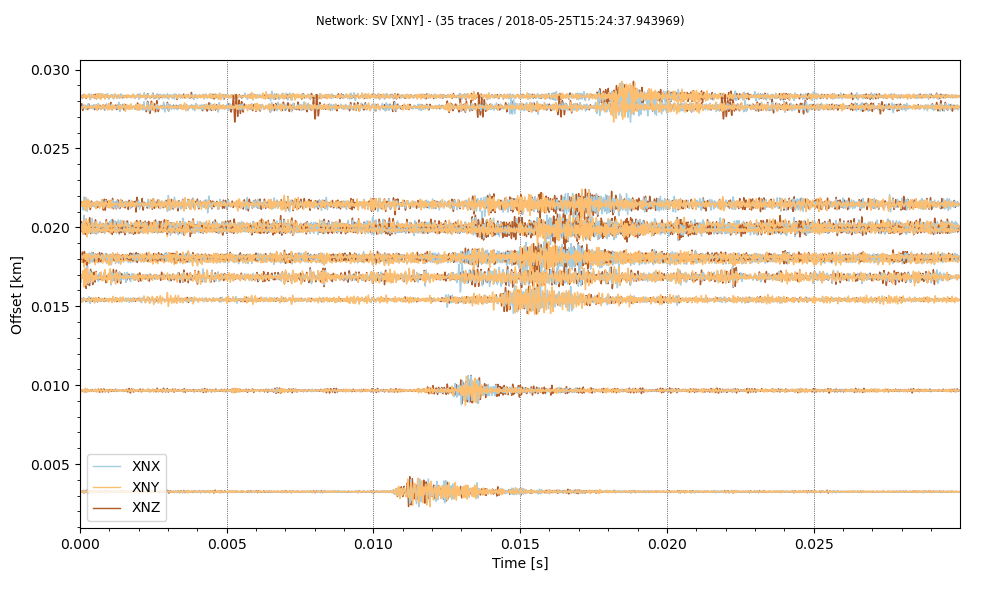

In [6]:
accels =st[24:].plot(type='section',scale=2,orientation='horizontal',color='channel',handle=True,alpha=1.0)

In [ ]:
from obspy.signal.array_analysis import array_processing
from obspy.imaging.cm import obspy_sequential
stime=st[0].stats.starttime
etime=st[0].stats.endtime
kwargs = dict(
    # slowness grid: X min, X max, Y min, Y max, Slow Step
    sll_x=-6.0, slm_x=6.0, sll_y=-6.0, slm_y=6.0, sl_s=0.06,
    # sliding window properties
    win_len=0.001, win_frac=0.0005,
    # frequency properties
    frqlow=5000.0, frqhigh=20000.0, prewhiten=0,
    # set coord system
    coordsys='xy',
    # restrict output
    semb_thres=-1e9, vel_thres=-1e9, timestamp='mlabday',
    stime=stime, etime=etime
)
out = array_processing(st[:4], **kwargs)

In [ ]:
# Plot
labels = ['rel.power', 'abs.power', 'baz', 'slow']

xlocator = mdates.AutoDateLocator()
fig = plt.figure()
for i, lab in enumerate(labels):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
               edgecolors='none', cmap=obspy_sequential)
    ax.set_ylabel(lab)
    ax.set_xlim(out[0, 0], out[-1, 0])
    ax.set_ylim(out[:, i + 1].min(), out[:, i + 1].max())
    ax.xaxis.set_major_locator(xlocator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))

fig.suptitle('EGS Collab Experiment 1 MEQ %s' % (
    stime.strftime('%Y-%m-%d'), ))
fig.autofmt_xdate()
fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0)
plt.show()